<a href="https://colab.research.google.com/github/Hamza1122/Face-Spoofing-Detection/blob/main/new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

In [ ]:
NUM_CLASSES = 2

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'


In [ ]:
# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

In [ ]:
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [ ]:

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights ='imagenet'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = 'adam', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


Using TensorFlow backend.


In [ ]:
# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        'spoof_dataset/Train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'spoof_dataset/Test',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 20995 images belonging to 2 classes.
Found 3570 images belonging to 2 classes.


In [ ]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 210, 100, 36)

In [ ]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
10/10 [==============================] - 898s 90s/step - loss: 0.3675 - acc: 0.8560 - val_loss: 0.5086 - val_acc: 0.7060
Epoch 2/10
10/10 [==============================] - 835s 83s/step - loss: 0.0667 - acc: 1.0000 - val_loss: 0.2317 - val_acc: 0.9400
Epoch 3/10
10/10 [==============================] - 998s 100s/step - loss: 0.0304 - acc: 1.0000 - val_loss: 0.1024 - val_acc: 0.9960
Epoch 4/10
10/10 [==============================] - 895s 89s/step - loss: 0.0184 - acc: 1.0000 - val_loss: 0.0926 - val_acc: 0.9950
Epoch 5/10
10/10 [==============================] - 618s 62s/step - loss: 0.0121 - acc: 1.0000 - val_loss: 0.1026 - val_acc: 0.9910
Epoch 6/10
10/10 [==============================] - 659s 66s/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.0443 - val_acc: 1.0000
Epoch 7/10
10/10 [==============================] - 695s 69s/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0601 - val_acc: 0.9980
Epoch 8/10
10/10 [==============================] - 652s 65s/step - loss: 0

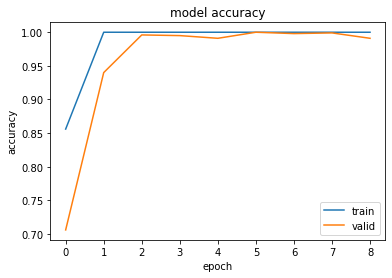

In [ ]:
    
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    

plt.show()

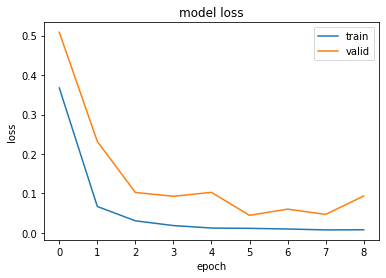

In [ ]:
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
import tensorflow as tf

from keras.models import load_model

model.save('spoofing_new_dataset_model.h5')

In [ ]:
test_generator = data_generator.flow_from_directory(
    directory = 'F:/Dataset/test_dataset/',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)


Found 27 images belonging to 2 classes.


In [ ]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

27/27 [==============================] - 6s 224ms/step


In [ ]:
TEST_DIR + test_generator.filenames[1]

'F:/Dataset/test_dataset/live\\live1_210.jpg'

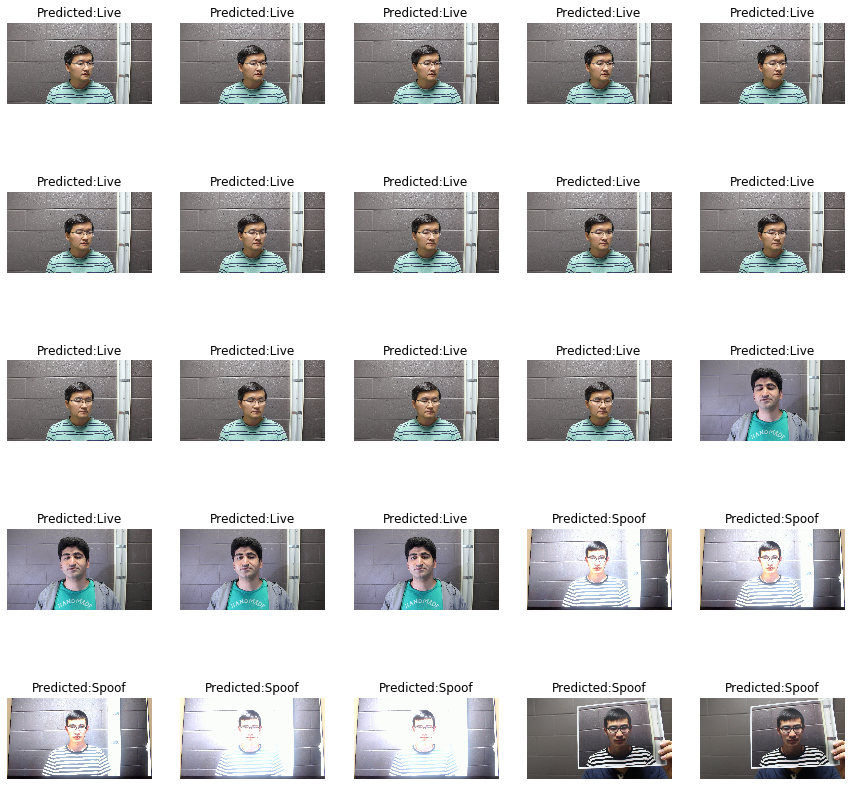

In [ ]:
TEST_DIR = 'F:/Dataset/test_dataset/'
f, ax = plt.subplots(5,5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Spoof" if predicted_class_indices[i] else "Live"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()